In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('../data/alpha_thalassemia.csv')

df['target'] = df['target'].map({
	1: "normal",
	2: "silent",
	3: "trait",
	4: "HbH"
})

df['sex'] = df['sex'].map({
	1: "female",
	2: "male"
})

# Remove Outliers
df = df[df['MCHC'] != df['MCHC'].max()]
df = df[df['RBC'] != df['RBC'].max()]

class_mapping = {'normal': 0, 'silent': 1, 'trait': 2, 'HbH': 3}

# Applicare la mappatura al target
df['target'] = df['target'].map(class_mapping)

In [4]:
RANDOM_STATE = 42

# SCALER
scaler = StandardScaler()

# STRATIFIED KFOLD
skf = StratifiedKFold(
	n_splits = 10,
	shuffle = True,
	random_state = RANDOM_STATE
)

palette = sns.color_palette("Set2", n_colors = df['target'].nunique())
class_name = ['normal', 'silent', 'trait', 'HbH']

In [5]:
def process(X, y, SCALE = True, OVERSAMPLING = True):

	# SPLIT DATA
	X_train, X_test, y_train, y_test = train_test_split(
		X,
		y,
		test_size = 0.3,
		shuffle = True,
		random_state = RANDOM_STATE,
		stratify = y
	)

	# SCALE
	if SCALE:
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

	# SMOTE
	if OVERSAMPLING:
		smote = SMOTE(random_state = RANDOM_STATE)
		X_train, y_train = smote.fit_resample(X_train, y_train)
	
	return X_train, X_test, y_train, y_test

def plot_roc(y_test, y_test_prob):
	fpr = dict()
	tpr = dict()
	roc_auc = dict()

	# Calcola la curva ROC per ciascuna classe
	for i in range(4):  # Le classi 0, 1, 2, 3
		fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_prob[:, i])
		roc_auc[i] = auc(fpr[i], tpr[i])

	# Plotta le curve ROC
	plt.figure(figsize=(10, 8))
	for i in range(4):
		plt.plot(fpr[i], tpr[i], label=f'ROC curve {class_name[i]} (AUC = {roc_auc[i]:.2f})', color=palette[i])

	plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC Curve')
	plt.legend(loc="lower right")
	plt.show()

def plot_cm(y_test, y_test_p):
	cm = confusion_matrix(y_test, y_test_p)
	disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'silent', 'trait', 'HbH'])
	disp.plot(cmap = 'Blues')
	plt.title('Confusion Matrix')
	plt.show()


Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.78      0.79      0.78       224
           1       0.72      0.72      0.72       224
           2       0.86      0.88      0.87       224
           3       0.94      0.91      0.93       224

    accuracy                           0.83       896
   macro avg       0.83      0.83      0.83       896
weighted avg       0.83      0.83      0.83       896


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.79      0.81        96
           1       0.66      0.76      0.71        72
           2       0.97      0.86      0.91        79
           3       0.71      0.91      0.80        11

    accuracy                           0.81       258
   macro avg       0.80      0.83      0.81       258
weighted avg       0.82      0.81      0.81       258



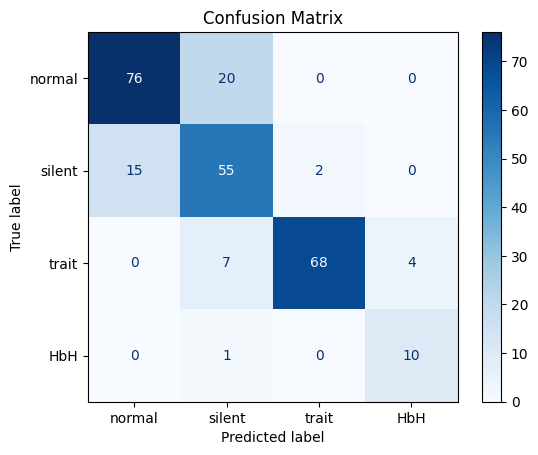

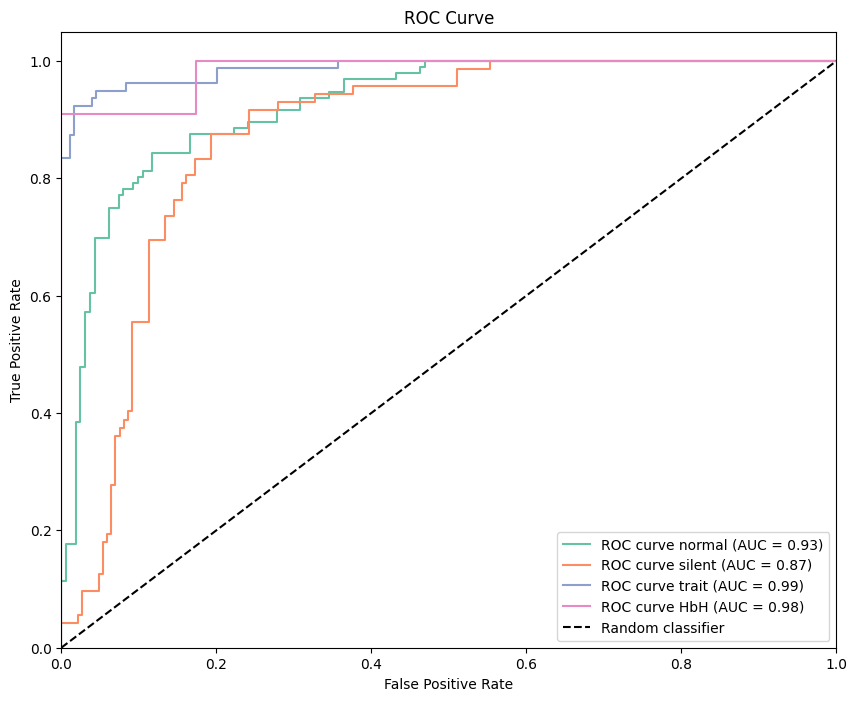

In [6]:
# MODEL 1 - MANUAL SELECTION WITH / WITHOUT SMOTE
X = df[['HB', 'MCV', 'RBC']]
y = df['target']

X_train, X_test, y_train, y_test = process(X, y, OVERSAMPLING = True)

model = LogisticRegression(random_state = RANDOM_STATE)

y_train_p_cv = cross_val_predict(model, X_train, y_train, cv = skf)

print("\nClassification Report (Cross-Validation):\n", classification_report(y_train, y_train_p_cv))

model.fit(X_train, y_train)
y_test_p = model.predict(X_test)

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_p))

# CONFUSION MATRIX
plot_cm(y_test, y_test_p)

# RPC AUC
y_test_prob = model.predict_proba(X_test)
plot_roc(y_test, y_test_prob)



Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       224
           1       0.75      0.75      0.75       224
           2       0.94      0.91      0.92       224
           3       0.97      1.00      0.98       224

    accuracy                           0.86       896
   macro avg       0.86      0.86      0.86       896
weighted avg       0.86      0.86      0.86       896


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.81      0.83        96
           1       0.70      0.82      0.76        72
           2       1.00      0.90      0.95        79
           3       0.83      0.91      0.87        11

    accuracy                           0.84       258
   macro avg       0.85      0.86      0.85       258
weighted avg       0.86      0.84      0.85       258



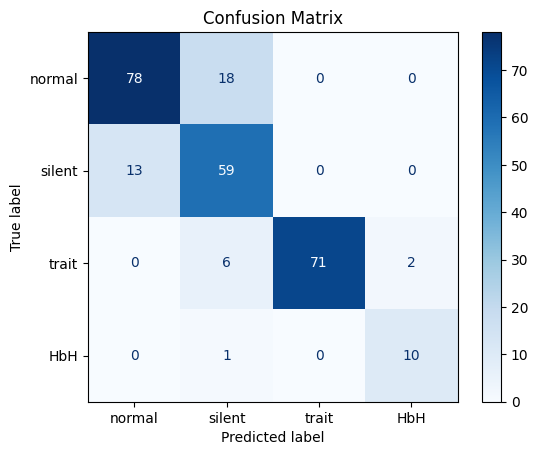

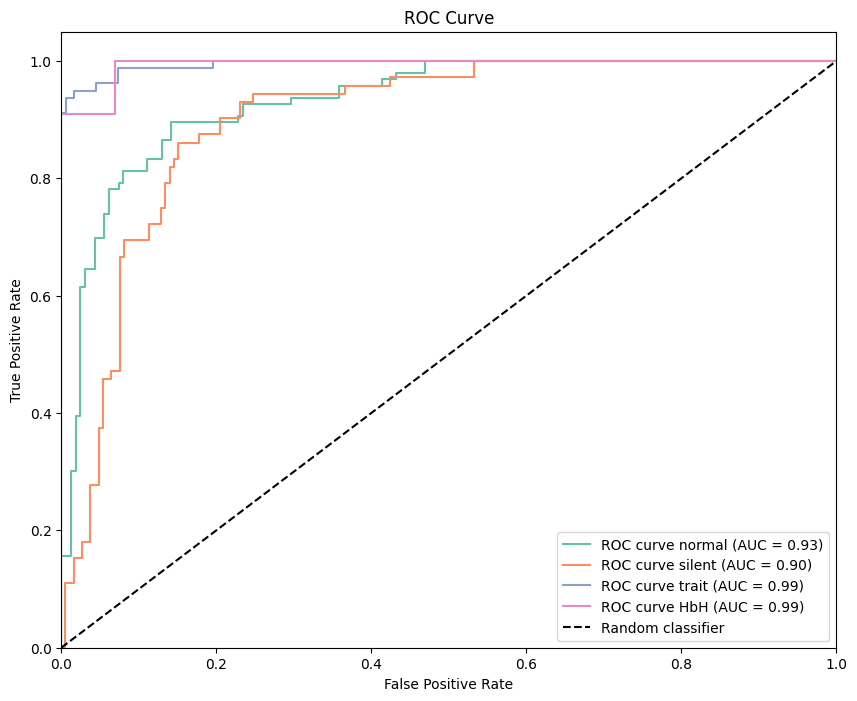

In [7]:
# MODEL 2 - Recursive Feature Elimination
X = df[['HB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW', 'RBC']]
y = df['target']

X_train, X_test, y_train, y_test = process(X, y, OVERSAMPLING = True)

model = LogisticRegression(random_state = RANDOM_STATE)

# 2 WITHOUT OVERSAMPLIG, 5 WITH OVERSAMPLING
rfe = RFE(estimator = model, n_features_to_select = 5)

X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# SHOW IMPORTANCE
"""
for feature, selected in zip(X.columns, rfe.support_):
	if selected:
		print(feature)

for feature, rank in zip(X.columns, rfe.ranking_):
	print(f"{feature}: {rank}")
"""

y_train_p_cv = cross_val_predict(model, X_train_rfe, y_train, cv = skf)

print("\nClassification Report (Cross-Validation):\n", classification_report(y_train, y_train_p_cv))

model.fit(X_train_rfe, y_train)
y_test_p = model.predict(X_test_rfe)

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_p))

# CONFUSION MATRIX
plot_cm(y_test, y_test_p)

# RPC AUC
y_test_prob = model.predict_proba(X_test_rfe)
plot_roc(y_test, y_test_prob)

Varianza spiegata da ciascun componente PCA: [0.70568568 0.2117651  0.04790348]

Classification Report (Cross-Validation):
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       224
           1       0.74      0.75      0.75       224
           2       0.94      0.89      0.92       224
           3       0.97      1.00      0.98       224

    accuracy                           0.86       896
   macro avg       0.86      0.86      0.86       896
weighted avg       0.86      0.86      0.86       896


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.80      0.79      0.80        96
           1       0.67      0.74      0.70        72
           2       0.99      0.90      0.94        79
           3       0.83      0.91      0.87        11

    accuracy                           0.81       258
   macro avg       0.82      0.83      0.83       258
weighted avg       0.82      

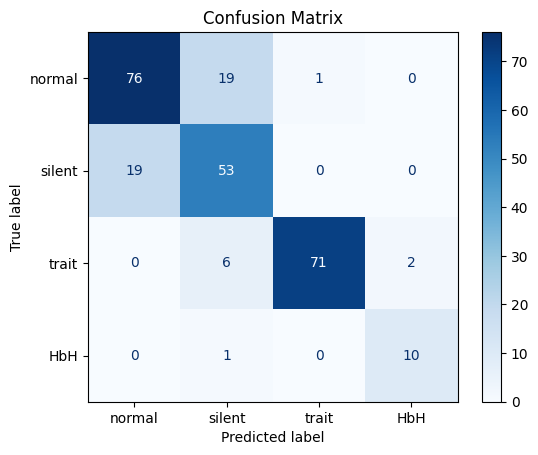

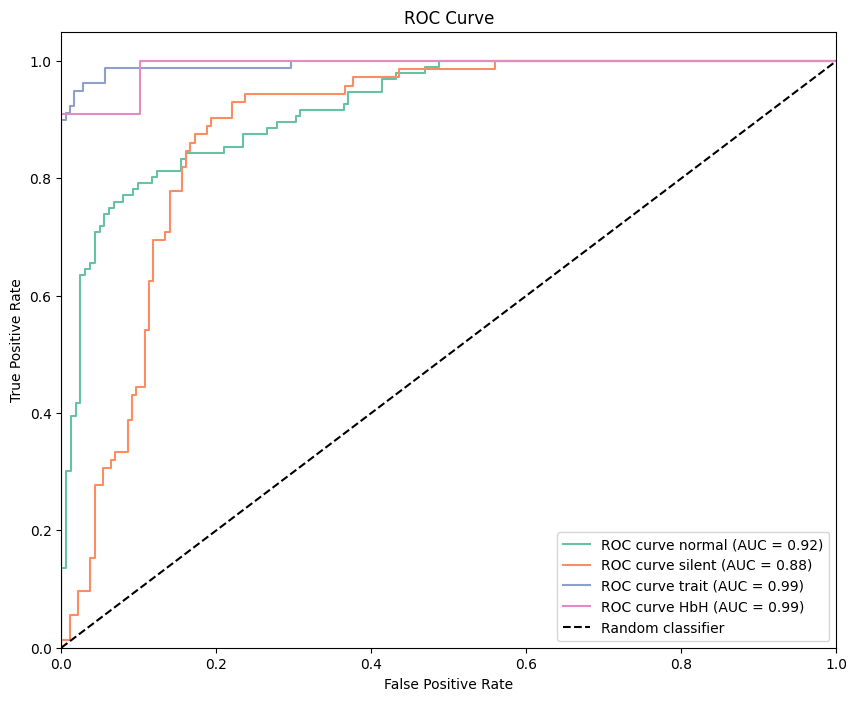

In [8]:
# MODEL 3 - PCA
X = df[['HB', 'HCT', 'MCV', 'MCH', 'MCHC', 'RDW', 'RBC']]
y = df['target']

X_train, X_test, y_train, y_test = process(X, y, OVERSAMPLING = True)

pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PLOT PCA
"""
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='black')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()
"""

# CHECK IF COMPONENTS ARE INDEPENDENT
"""
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_pca_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_pca_df.values, i) for i in range(X_train_pca_df.shape[1])]
print(vif_data)
"""

print(f"Varianza spiegata da ciascun componente PCA: {pca.explained_variance_ratio_}")

model = LogisticRegression(random_state = RANDOM_STATE)

# SKF
y_train_p_cv = cross_val_predict(model, X_train_pca, y_train, cv = skf)
print("\nClassification Report (Cross-Validation):\n", classification_report(y_train, y_train_p_cv))

# TEST
model.fit(X_train_pca, y_train)
y_test_p = model.predict(X_test_pca)
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_p))

# CONFUSION MATRIX
plot_cm(y_test, y_test_p)

# ROC AUC
y_test_prob = model.predict_proba(X_test_pca)
plot_roc(y_test, y_test_prob)